<a href="https://colab.research.google.com/github/Jayani/CE888/blob/main/Lab_4/my_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab4-recommender/jester-data-1.csv", header=None)

In [3]:
df = df[np.arange(1,101,1)].replace(99.00,np.nan)
df.columns = df.columns-1
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.42,NaN,NaN,NaN,-7.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.00,2.77,8.30,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,NaN,NaN,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,NaN,8.25,NaN,NaN,7.48,7.28,7.28,8.93,NaN,6.17,7.28,NaN,NaN,8.98,7.33,NaN,6.17,9.08,7.33,...,6.46,7.28,NaN,NaN,7.04,7.28,NaN,7.28,8.25,NaN,NaN,NaN,NaN,NaN,NaN,8.93,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.03,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,NaN,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,NaN,NaN,NaN,NaN,2.91,3.93,6.75,6.60,NaN,6.65,-6.12,NaN,7.57,6.21,6.65,NaN,-8.30,7.18,2.82,...,0.00,-3.69,NaN,NaN,7.82,0.24,NaN,7.28,-2.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.63,NaN,NaN,-2.33,NaN,NaN,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,NaN,NaN,NaN,NaN,NaN,NaN,4.13,NaN,NaN,NaN,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,-0.53,5.63,-7.14,-4.08,-3.50,-8.20,-3.98,-9.22,-0.15,-6.46,5.63,-0.92,-2.91,-4.17,2.82,3.40,8.64,6.84,6.80,-0.87,7.38,-3.50,8.88,7.43,5.39,2.23,-0.68,3.40,-0.58,4.42,...,8.59,3.45,0.87,9.27,-4.66,5.73,-0.49,8.35,1.94,5.00,-9.66,8.98,8.98,-9.81,9.13,9.08,9.08,3.98,0.73,9.03,8.98,9.22,8.93,9.13,9.27,-1.99,-9.95,-9.90,9.13,8.83,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,8.88,-8.69,-7.48,-8.83,-1.75,6.60,3.54,1.50,7.67,-0.44,9.22,8.74,9.03,9.08,8.93,3.74,3.20,-9.17,-8.98,8.79,-7.67,-3.06,9.13,8.40,-0.63,-7.18,0.58,8.88,9.27,8.50,...,2.77,8.11,-7.96,8.93,-0.87,-5.87,8.88,-1.12,-8.74,8.74,NaN,NaN,NaN,NaN,NaN,4.90,NaN,NaN,NaN,NaN,-0.29,0.92,-0.78,0.15,-0.10,0.00,-0.19,-0.87,-1.36,-0.58,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,NaN,NaN,-6.46,-1.65,-6.80,-6.41,-6.99,7.23,6.75,-6.99,6.55,NaN,NaN,NaN,NaN,0.49,-0.53,-6.94,-0.49,NaN,6.46,-0.53,NaN,NaN,-7.86,-0.34,NaN,-6.94,NaN,NaN,...,0.49,-0.24,NaN,NaN,-3.11,-6.65,NaN,-0.58,6.31,NaN,NaN,-7.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,NaN,NaN,-9.47,NaN,3.45,-0.92,-4.51,-4.13,-5.73,-9.51,2.82,NaN,NaN,NaN,NaN,-0.49,2.91,2.62,8.30,NaN,3.06,5.44,NaN,NaN,-0.68,2.04,NaN,NaN,1.55

In [4]:
df.loc[2723,35]

-2.04

In [5]:
max = -10
max_id = 0
min_id = 0
min = 10

for col in df.columns:
  mean = df[col].dropna().mean()
  if mean > max:
    max = mean
    max_id = col
  if mean < min:
    min = mean
    min_id = col

In [6]:
print("Best Rated Joke and its avg rating : %i,%.2f , Worst Rated Joke and its avg rating : %i,%.2f"%(max_id,max,min_id,min))

Best Rated Joke and its avg rating : 49,3.67 , Worst Rated Joke and its avg rating : 57,-3.83


In [7]:
def replace(df,p):
    df_new = df.copy() 
    arr = df.values
    rated = np.where(arr != np.nan)
    n_rated = len(rated[0])
    idx = np.random.choice(n_rated, size=int(p*n_rated), replace=False)
    df_new.loc[rated[0][idx], rated[1][idx]] = np.nan
    return df_new, (rated[0][idx], rated[1][idx])

In [8]:
df_train, val_idx = replace(df,0.1)

In [9]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
n_latent_factors = 2
user_ratings = df.values
latent_user_preferences = np.random.random((user_ratings.shape[0], n_latent_factors))
latent_item_features = np.random.random((user_ratings.shape[1], n_latent_factors))

In [11]:
def predict_rating(user_id, item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)


def train(user_id, item_id, rating, alpha=0.0001):
    #print(item_id)
    predicted_rating = predict_rating(user_id, item_id)
    err =  predicted_rating - rating
    #print(err)
    user_pref_values = latent_user_preferences[user_id]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    

def sgd(iterations):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    mse_history = []
    for iteration in range(iterations):
        error = []
        for user_id in range(latent_user_preferences.shape[0]):
            for item_id in range(latent_item_features.shape[0]):
                rating = user_ratings[user_id, item_id]
                if not np.isnan(rating):
                    err = train(user_id, item_id, rating)
                    error.append(err)
        mse = (np.array(error) ** 2).mean()   
        if (iteration % 10) == 0:
            print('Iteration %d/%d:\tMSE=%.6f' % (iteration, iterations, mse))
            mse_history.append(mse)
    return mse_history

Iteration 0/100:	MSE=26.201582
Iteration 10/100:	MSE=23.008329
Iteration 20/100:	MSE=20.290359
Iteration 30/100:	MSE=17.684806
Iteration 40/100:	MSE=17.266663
Iteration 50/100:	MSE=17.174076
Iteration 60/100:	MSE=17.145631
Iteration 70/100:	MSE=17.136248
Iteration 80/100:	MSE=17.133236
Iteration 90/100:	MSE=17.132487


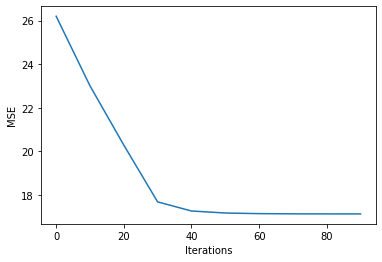

In [12]:
num_iter = 100
hist = sgd(num_iter)  # Note how the MSE decreases with the number of iterations
plt.figure()
plt.plot(np.arange(0, num_iter, 10), hist)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.show()

In [13]:
predictions = latent_user_preferences.dot(latent_item_features.T)
predictions

array([[-3.90657162, -4.16294675, -5.63133832, ..., -2.46434245,
        -6.22152146, -2.59655029],
       [ 2.98089436,  3.14263396,  3.78321203, ...,  2.51110042,
         3.96289479,  2.75909337],
       [ 6.88661174,  7.17744029,  7.48435867, ...,  7.34290707,
         7.23789662,  8.27542699],
       ...,
       [-1.06025897, -1.12490023, -1.45347168, ..., -0.76077478,
        -1.57419374, -0.81810254],
       [-1.96889218, -2.10503132, -2.94319321, ..., -1.11308377,
        -3.29597217, -1.14964179],
       [ 2.79089001,  2.87523177,  2.5249267 , ...,  3.59968897,
         2.15731472,  4.12312776]])

In [14]:
values = [zip(user_ratings[i], predictions[i]) for i in range(predictions.shape[0])]
comparison_df_train = pd.DataFrame(values)
comparison_df_train.columns = df_train.columns

In [15]:
comparison_df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,"(-7.82, -3.9065716152869667)","(8.79, -4.162946747371624)","(-9.66, -5.63133831868749)","(-8.16, -9.541658538558956)","(-7.52, -2.657990153546846)","(-8.5, -1.7791613486052698)","(-9.85, -4.884511911960946)","(4.17, -4.295550740934698)","(-8.98, -8.845619071983318)","(-4.76, -3.7258444232228523)","(-8.5, -1.5950507430906395)","(-6.75, -1.7267922219157439)","(-7.18, -6.479903059483552)","(8.45, -1.5597351767361298)","(-7.18, -6.532192365795192)","(-7.52, -9.967510788083766)","(-7.43, -4.433409700152961)","(-9.81, -5.267481331998296)","(-9.85, -3.8014777974863745)","(-9.85, -6.105497383293518)","(-9.37, 0.4330348189851821)","(1.5, -4.297528458810081)","(-4.37, -6.087698944712217)","(-9.81, -10.56386718705363)","(-8.5, -4.63406399093379)","(1.12, -1.5602140440607493)","(7.82, 3.4266902854497387)","(2.86, -1.6748779076621583)","(9.13, 3.4933891430999404)","(-7.43, -7.929974542924696)","(2.14, 1.1164828465809369)","(-4.08, 3.2383200457224652)","(-9.08, -9.42792656232248)","(7.82, -2.675725004336296)","(5.05, 2.8529923450610846)","(4.95, 3.672202716355329)","(-9.17, -9.118453058147058)","(-8.4, -3.4568407034266433)","(-8.4, -2.4952406385917705)","(-8.4, -3.661143357890271)",...,"(8.59, 1.2043971153737514)","(3.59, 2.1062608545013872)","(-6.84, -5.403928486589099)","(-9.03, -8.315880009972386)","(2.82, 1.3497812936097215)","(-1.36, 1.5238445454171565)","(-9.08, -8.798250674336066)","(8.3, 1.7363103419035066)","(5.68, 1.770087193808639)","(-4.81, -4.654430840717913)","(nan, -6.815079109828956)","(nan, 1.149465116071881)","(nan, -3.3972929856478533)","(nan, -9.221966314987688)","(nan, -6.063489607138473)","(nan, 0.5267614426106276)","(nan, -4.248743363080421)","(-9.42, -2.2951790609054976)","(nan, -5.413380151707568)","(nan, -2.7301305897468997)","(nan, -1.3527971796293692)","(-7.72, -4.668195511318061)","(nan, -0.3818682523067607)","(nan, -4.853303225685254)","(nan, -4.195645950155635)","(nan, -6.2725093603193285)","(nan, -1.1628063801858601)","(nan, -1.2925428892966297)","(nan, 3.13932698600678)","(nan, -5.3532801990555265)","(2.82, -1.5325006306979547)","(nan, -3.2434856191464085)","(nan, 0.19418422913037778)","(nan, -4.77201683869229)","(nan, -3.9731453751343877)","(nan, -2.916924733812984)","(-5.63, -2.2129107932980214)","(nan, -2.4643424452846423)","(nan, -6.221521458508306)","(nan, -2.5965502907375457)"
1,"(4.08, 2.9808943582416165)","(-0.29, 3.142633963146118)","(6.36, 3.783212029275744)","(4.37, 5.266538725041904)","(-2.38, 2.2016745818815275)","(-9.66, 2.5170151738172173)","(-0.73, 2.9585558735485855)","(-5.34, 2.3188262014250496)","(8.88, 5.073667041452239)","(9.22, 2.991467666934861)","(6.75, 2.384390926915807)","(8.64, 2.5546975302830517)","(4.42, 3.1428276722417485)","(7.43, 2.4750714449049664)","(4.56, 3.0138606865012534)","(-0.97, 4.3071967362026955)","(4.66, 2.4478739844827)","(-0.68, 2.938888780208686)","(3.3, 2.7134877252875174)","(-1.21, 3.576210702582765)","(0.87, 1.613271070941325)","(8.64, 3.4817786840156657)","(8.35, 4.010438212989596)","(9.17, 5.516640675184981)","(0.05, 3.5332103765731855)","(7.57, 2.418520413949219)","(4.71, 0.23001882009695115)","(0.87, 2.385668857991535)","(-0.39, 0.11573698338818951)","(6.99, 4.867860039591357)","(6.5, 1.245122967141058)","(-0.92, 0.3175718205601738)","(7.14, 5.212874872275659)","(9.03, 2.759902999570249)","(-1.8, 0.5168405205083669)","(0.73, 0.045446853538844686)","(7.09, 4.851069159894548)","(3.4, 3.0608720425950815)","(-0.87, 2.782342323646676)","(7.91, 3.2124307750253864)",...,"(-6.7, 1.3006680191720932)","(-3.35, 0.8783896732914359)","(-9.03, 3.7863495053869114)","(4.47, 4.7175148923823205)","(4.08, 1.1475135482048189)","(-3.83, 1.068711760162329)","(8.74, 4.9523487871956915)","(1.12, 0.9432028733512741)","(0.78, 1.0051095498310918)",

In [18]:
dm = pd.read_excel("/content/drive/MyDrive/movies_latent_factors.xlsx")
dm

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,11,Star Wars: Episode IV - A New Hope (1977),-1.521848,-1.038507,2.027269,0.247933,-0.594548,2.513260,-1.848910,0.476710,-0.224146,-0.760681,-0.973915,0.862379,0.403861,1.129616,-0.248806
1,12,Finding Nemo (2003),-0.342185,-0.296586,-0.385962,2.443297,-1.097015,-0.619465,0.572887,0.329516,-0.712228,0.323554,-0.561948,-0.142405,-0.564415,0.506876,1.274993
2,13,Forrest Gump (1994),-2.240888,-0.438815,-2.275177,0.614548,0.904469,0.711919,-0.420876,1.302036,-0.868418,-0.160122,0.633667,0.133138,-0.330276,-2.209004,-0.419092
3,14,American Beauty (1999),-0.634531,2.186059,-0.066681,0.086197,0.517558,-0.185319,-0.412352,0.063841,0.075937,-0.577682,0.526803,-1.465557,-0.819682,0.549010,-0.681191
4,22,Pirates of the Caribbean: The Curse of the Bla...,0.517348,-1.456763,0.369161,0.073903,-0.098332,-0.594722,0.828888,0.033626,-0.707414,0.717877,1.394326,-0.786986,1.429191,0.855746,-2.292566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9806,The Incredibles (2004),0.159967,-0.051123,0.311183,1.841867,-1.952736,-0.836041,0.639252,-0.413082,-0.310868,0.448225,-0.846044,-0.158192,-0.649164,0.045580,1.017861
96,10020,Beauty and the Beast (1991),1.286288,0.004957,-0.157640,2.579640,-0.042687,-0.256582,-0.007971,0.458163,0.091394,0.323339,-0.862833,-0.508185,0.994535,0.868700,-0.487076
97,36657,X-Men (2000),0.811901,-0.893280,0.668953,-0.885074,-1.070468,-0.973154,-0.037449,-0.925609,-0.122112,-0.328822,-0.163103,-0.307299,0.642105,-1.355542,0.067790
98,36658,X2: X-Men United (2003),1.161006,-0.715613,0.712633,-0.688808,-0.717785,-1.007047,-0.267268,-0.802322,-0.249239,-0.540419,-0.291422,-0.240216,0.290714,-1.217250,-0.288130


In [20]:
du = pd.read_excel("/content/drive/MyDrive/movies_latent_factors.xlsx",sheet_name=1)
du

,User,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
0,4768,-0.204024,0.161079,-0.090447,0.138495,-0.162934,0.163894,0.051502,-0.088582,0.126829,0.065967,0.085008,0.355404,0.007108,-0.118663,-0.039125
1,156,-0.189652,-0.178979,-0.091490,-0.000823,-0.032646,0.177209,-0.098123,-0.068283,-0.011575,0.120866,-0.009931,-0.048606,0.045916,0.113671,0.179873
2,5323,-0.115308,-0.090886,-0.053129,0.018472,-0.068081,-0.004828,0.113005,0.102107,0.034758,0.000693,-0.073712,-0.019460,0.108372,0.054471,-0.109552
3,174,-0.227462,-0.272532,-0.017231,0.054324,0.214755,-0.072639,-0.033122,-0.086508,-0.131479,0.180403,0.095890,-0.082396,0.036767,-0.165438,0.050692
4,4529,-0.014616,-0.102218,-0.107935,0.155784,-0.123362,-0.118228,-0.013549,-0.050622,0.058698,-0.159600,-0.142382,-0.132836,-0.039897,0.129063,0.102669
5,783,-0.020301,-0.031919,-0.036955,0.033690,0.000174,-0.003178,0.054474,0.045424,-0.053308,0.003437,-0.041750,0.059725,-0.021647,0.039873,-0.061857
6,3878,-0.091462,0.215879,-0.180453,0.085408,-0.321094,0.227947,0.053767,0.038017,0.097141,-0.139872,0.029253,0.214467,0.189250,0.065990,0.102776
7,768,0.000819,-0.009229,-0.019228,0.002703,0.012869,0.006655,0.007687,0.018747,0.014705,-0.009256,-0.010116,-0.010051,-0.002108,0.043223,-0.006670
8,4469,-0.030528,-0.011537,-0.042822,-0.014378,0.031338,0.012297,-0.000038,-0.010264,-0.006781,-0.019950,-0.014435,0.010926,0.024400,0.005318,-0.007983
9,1882,-0.083093,-0.029160,0.013748,0.022716,-0.062732,-0.080670,-0.019723,0.013253,-0.091305,-0.090687,0.030638,-0.113364,-0.021325,0.181508,0.022357


In [21]:
dm[dm["Movie ID"] == 671]["Factor5"]

57    0.536773
Name: Factor5, dtype: float64

In [22]:
dm[dm["Factor2"] == dm["Factor2"].min()]

,Movie ID,Title,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,Factor11,Factor12,Factor13,Factor14,Factor15
16,122,The Lord of the Rings: The Return of the King ...,-2.27111,-2.5263,2.142566,0.341954,2.688624,-0.36061,1.140343,-0.932931,1.356982,1.331742,-0.454221,-0.620533,-0.638745,-0.172093,-0.314937


In [23]:
np.array(du[du["User"] == 783].drop("User", axis = 1)).shape

(1, 15)

In [24]:
def m_predict(uid,mid):
  return np.squeeze(np.array(du[du["User"] == uid].drop("User", axis = 1)).dot(np.array(dm[dm["Movie ID"] == mid].drop(["Movie ID","Title"], axis = 1)).T))

In [25]:
m_predict(783,558)

array(-0.12246388)

In [26]:
m_predict(3806,558)

array(-0.56242976)

In [27]:
def topn(uid, n): 
  rat = []
  for id in dm["Movie ID"].values:
    pred = m_predict(uid,id).item()
    rat.append((id,pred))
  rat.sort(key=lambda x:x[1], reverse=True)
  return rat[0:n]

In [28]:
topn(3806, 2)

[(603, 0.8928390521025773), (854, 0.872107216953862)]

In [29]:
topn(156, 3)

[(603, 1.0522554619985223),
 (1891, 0.9102336968038713),
 (1892, 0.8852081243380692)]